In [ ]:
!pip install transformers datasets seqeval scikit-learn


In [ ]:
!pip install datasets transformers seqeval scikit-learn pandas
!pip install torch


In [ ]:
import transformers
import datasets
import torch


In [ ]:
import os
os.makedirs("data", exist_ok=True)

from datasets import load_dataset
import pandas as pd

In [ ]:
# auto_annotate_ner.py
import os
import re
from datasets import load_dataset

# -------- CONFIG --------
OUTPUT_CONLL = "data/auto_ner.conll"
NUM_SAMPLES = None          # increase if you want more
TEXT_COL = "Long Description"   # from your dataset columns

os.makedirs("data", exist_ok=True)

# --- keyword lists (very expandable) ---

PROGRAMMING_LANGS = {
    "python", "java", "javascript", "typescript", "ts", "c", "c++", "c#", "go",
    "golang", "rust", "php", "ruby", "scala", "kotlin", "swift", "sql", "r"
}

FRAMEWORKS = {
    "react", "angular", "vue", "django", "flask", "spring", "springboot",
    "spring-boot", "pytorch", "tensorflow", "keras", "node", "nodejs",
    "node.js", "express", "laravel", "symfony", "rails", "fastapi", "redux",
    "asp.net", "asp", ".net", ".netcore", ".net-core", "webapi", "web api",
    "entity framework", "sqlalchemy", "celery"
}

TOOLS = {
    "aws", "azure", "gcp", "google cloud", "docker", "kubernetes", "k8s",
    "git", "github", "gitlab", "bitbucket", "jenkins", "jira", "heroku",
    "linux", "snowflake", "bigquery", "redshift", "airflow", "terraform",
    "ansible", "mongodb", "mongo", "postgres", "postgresql", "mysql",
    "oracle", "cassandra", "kafka", "hadoop", "shopify", "ebay", "walmart",
    "excel", "google sheets", "google sheet"
}

SKILL_TECH = {
    "devops", "machine learning", "deep learning", "ml", "dl",
    "microservices", "rest", "graphql", "cloud", "blockchain",
    "e-commerce", "ecommerce", "seo", "ppc", "ci/cd", "ci cd",
    "data engineering", "data analysis", "data analytics",
    "data scientist", "data science"
}

EDU_LEVEL_PATTERNS = [
    r"bachelor'?s degree", r"bachelors degree", r"bachelor degree",
    r"master'?s degree", r"masters degree", r"master degree",
    r"phd", r"ph\.d", r"b\.sc", r"m\.sc", r"bsc", r"msc",
    r"b\.tech", r"m\.tech", r"btech", r"mtech"
]

DEGREE_MAJOR_PATTERNS = [
    "computer science", "software engineering", "information technology",
    "data science", "statistics", "mathematics", "electrical engineering",
    "cs", "it"
]

EMPLOYMENT_TYPE_PATTERNS = [
    "full-time", "full time", "part-time", "part time",
    "contract", "internship", "intern", "freelance", "permanent",
    "temporary"
]

# --- extra helper sets for better JOB_TITLE / COMPANY detection ---

JOB_HEAD_NOUNS = {
    "engineer", "developer", "scientist", "manager", "architect",
    "analyst", "specialist", "consultant", "administrator", "devops",
    "designer", "director", "lead", "intern", "tester", "qa", "author"
}

JOB_MODIFIERS = {
    "senior", "sr", "junior", "jr", "principal", "staff", "head",
    "lead", "chief", "associate", "assistant", "graduate"
}

JOB_CONTEXT_WORDS = {
    "software", "data", "backend", "front-end", "frontend", "fullstack",
    "full-stack", "ml", "ai", "product", "project", "cloud", "security",
    "qa", "test", "testing", "research", "systems", "mobile", "ios", "android"
}

COMPANY_STOPWORDS = {
    "we", "our", "the", "a", "an", "you", "they", "he", "she", "it", "and",
    "for", "with", "to", "of", "in"
}


def normalize(text: str) -> str:
    return text.strip().lower()


def find_span_matches(tokens, phrases, label):
    """
    tokens: list of lowercased tokens
    phrases: set/list of phrases in lowercase (may be multi-word)
    label: label string
    returns list of (start, end, label) spans (end exclusive)
    """
    spans = []
    n = len(tokens)
    phrase_tokens_list = [p.split() for p in phrases]

    for phrase_tokens in phrase_tokens_list:
        m = len(phrase_tokens)
        if m == 0:
            continue
        for i in range(n - m + 1):
            if tokens[i:i+m] == phrase_tokens:
                spans.append((i, i + m, label))
    return spans


def find_regex_spans(text, tokens, label, patterns):
    """
    text: original string
    tokens: list of tokens (original, not lowercased)
    patterns: list of regex or plain patterns
    returns spans (start_idx, end_idx, label) based on char search mapped back to tokens
    NOTE: very approximate but okay for auto-label.
    """
    spans = []
    lowered = text.lower()
    # build token char offsets
    offsets = []
    idx = 0
    for tok in tokens:
        start = text.find(tok, idx)
        if start == -1:
            start = idx  # fallback
        end = start + len(tok)
        offsets.append((start, end))
        idx = end

    for pat in patterns:
        # treat as regex
        for m in re.finditer(pat, lowered):
            s_char, e_char = m.start(), m.end()
            # map to token indices
            start_tok = None
            end_tok = None
            for i, (ts, te) in enumerate(offsets):
                if ts <= s_char < te:
                    start_tok = i
                if ts < e_char <= te:
                    end_tok = i + 1
            if start_tok is not None and end_tok is not None and start_tok < end_tok:
                spans.append((start_tok, end_tok, label))
    return spans


def auto_label_text(text: str):
    """
    Return tokens, tags (BIO) for one job description using simple rules.
    """
    # simple tokenization
    # keep punctuation as separate tokens
    tokens = re.findall(r"\w+|\S", text)
    if not tokens:
        return [], []

    lower_tokens = [t.lower() for t in tokens]
    spans = []

    # Programming languages
    spans += find_span_matches(lower_tokens, PROGRAMMING_LANGS, "PROGRAMMING_LANGUAGE")

    # Frameworks
    spans += find_span_matches(lower_tokens, FRAMEWORKS, "FRAMEWORK")

    # Tools (multi-word handled by split)
    spans += find_span_matches(lower_tokens, TOOLS, "TOOL")

    # Skill_tech
    spans += find_span_matches(lower_tokens, SKILL_TECH, "SKILL_TECH")

    # Employment type (regex-ish phrase match)
    spans += find_span_matches(lower_tokens, EMPLOYMENT_TYPE_PATTERNS, "EMPLOYEMENT_TYPE")

    # Education level
    spans += find_regex_spans(text, tokens, "EDUCATION_LEVEL", EDU_LEVEL_PATTERNS)

    # Degree major
    spans += find_span_matches(lower_tokens, DEGREE_MAJOR_PATTERNS, "DEGREE_MAJOR")

    # Remote / onsite as LOCATION
    for i, tok in enumerate(lower_tokens):
        if tok in {"remote", "remotely"}:
            spans.append((i, i+1, "LOCATION"))

    # --- Improved JOB_TITLE heuristic ---
    n = len(tokens)
    for i, tok in enumerate(lower_tokens):
        if tok in JOB_HEAD_NOUNS:
            # expand left and right around head noun
            start = i
            end = i + 1

            # expand left while previous is an allowed modifier/context word
            while start > 0:
                prev = lower_tokens[start - 1]
                # stop if punctuation or preposition that usually ends title
                if tokens[start - 1] in {",", ".", ";", ":", "(", ")"}:
                    break
                if prev in JOB_MODIFIERS or prev in JOB_CONTEXT_WORDS:
                    start -= 1
                else:
                    break

            # expand right for context words (e.g., "developer lead", "engineer intern")
            while end < n:
                nxt = lower_tokens[end]
                if tokens[end] in {",", ".", ";", ":", "(", ")"}:
                    break
                if nxt in JOB_CONTEXT_WORDS:
                    end += 1
                else:
                    break

            if end > start:
                spans.append((start, end, "JOB_TITLE"))

    # --- Improved COMPANY heuristic ---
    tech_words = PROGRAMMING_LANGS | FRAMEWORKS | TOOLS | SKILL_TECH | set(DEGREE_MAJOR_PATTERNS)
    preps = {"at", "for", "with", "by", "join", "joining"}

    for i, tok in enumerate(lower_tokens):
        if tok in preps and i + 1 < n:
            start = i + 1
            j = start
            # collect capitalized tokens that are not tech or job words
            while j < n:
                word = tokens[j]
                low = lower_tokens[j]
                if word in {",", ".", ";", ":", "(", ")", "-", "–"}:
                    break
                # stop if typical boundary word
                if low in {"in", "on", "from"}:
                    break
                # only keep if looks like a name (capitalized or all caps)
                if not (word[0].isupper() or word.isupper()):
                    break
                # skip obvious non-company words
                if low in COMPANY_STOPWORDS:
                    break
                if low in JOB_HEAD_NOUNS or low in JOB_CONTEXT_WORDS or low in JOB_MODIFIERS:
                    break
                if low in tech_words:
                    break
                j += 1

            if j > start:
                spans.append((start, j, "COMPANY"))

    # Remove overlaps (keep longer spans, then earlier ones)
    spans = sorted(spans, key=lambda x: (x[0], -(x[1] - x[0])))
    final_spans = []
    occupied = [False] * len(tokens)
    for s, e, lab in spans:
        if any(occupied[k] for k in range(s, e)):
            continue
        final_spans.append((s, e, lab))
        for k in range(s, e):
            occupied[k] = True

    # Build BIO tags
    tags = ["O"] * len(tokens)
    for s, e, lab in final_spans:
        tags[s] = f"B-{lab}"
        for k in range(s+1, e):
            tags[k] = f"I-{lab}"

    return tokens, tags


def main():
    print("Loading dataset...")
    ds = load_dataset("lang-uk/recruitment-dataset-job-descriptions-english")["train"]

    if NUM_SAMPLES is None:
        texts = ds[TEXT_COL]
    else:
        texts = ds[TEXT_COL][:NUM_SAMPLES]
    print(f"Annotating {len(texts)} samples...")

    with open(OUTPUT_CONLL, "w", encoding="utf-8") as f:
        for text in texts:
            if text is None:
                continue
            tokens, tags = auto_label_text(text)
            if not tokens:
                continue
            for tok, tag in zip(tokens, tags):
                f.write(f"{tok} {tag}\n")
            f.write("\n")

    print(f"Saved auto-labeled BIO data to {OUTPUT_CONLL}")


if __name__ == "__main__":
    main()


Loading dataset...
Annotating 141897 samples...
Saved auto-labeled BIO data to data/auto_ner.conll


In [ ]:
# Quick check: show first 40 lines of the generated BIO file
from itertools import islice

path = "data/auto_ner.conll"

with open(path, "r", encoding="utf-8") as f:
    for line in islice(f, 40):
        print(line.rstrip())


* O
Requirements O
* O
We O
' O
re O
looking O
for O
a O
long O
term O
collaboration O
with O
someone O
that O
has O
an O
experience O
in O
crypto O
, O
masternodes O
, O
nodes O
, O
validators O
etc O
. O
We O
need O
to O
set O
up O
: O
Kyber O
Network O
Nebulas O
SecretNetwork O
Tron O
Aion O


In [ ]:
def read_conll(path):
    """
    Reads a CoNLL/BIO file with format:
    token TAG
    ...
    (blank line between sentences)
    Returns: list_of_tokens, list_of_tags
    """
    sentences_tokens = []
    sentences_tags = []
    tokens, tags = [], []

    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()

            # sentence boundary
            if not line:
                if tokens:
                    sentences_tokens.append(tokens)
                    sentences_tags.append(tags)
                    tokens, tags = [], []
                continue

            parts = line.split()
            if len(parts) < 2:
                continue

            token = parts[0]
            tag = parts[-1]

            tokens.append(token)
            tags.append(tag)

    if tokens:
        sentences_tokens.append(tokens)
        sentences_tags.append(tags)

    return sentences_tokens, sentences_tags

tokens_list, tags_list = read_conll("data/auto_ner.conll")
len(tokens_list), tokens_list[0][:10], tags_list[0][:10]


(141897,
 ['*', 'Requirements', '*', 'We', "'", 're', 'looking', 'for', 'a', 'long'],
 ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'])

In [ ]:
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    DataCollatorForTokenClassification,
    TrainingArguments,
    Trainer,
)
import numpy as np
from seqeval.metrics import classification_report, f1_score

MODEL_NAME = "distilbert-base-uncased"

MAX_SENTENCES = 10000   # or 10000, etc.

tokens_small = tokens_list[:MAX_SENTENCES]
tags_small   = tags_list[:MAX_SENTENCES]

# Split into train/validation
train_tokens, val_tokens, train_tags, val_tags = train_test_split(
    tokens_small, tags_small, test_size=0.1, random_state=42
)

train_dataset = Dataset.from_dict({"tokens": train_tokens, "tags": train_tags})
val_dataset = Dataset.from_dict({"tokens": val_tokens, "tags": val_tags})
datasets_conll = DatasetDict({"train": train_dataset, "validation": val_dataset})

# Build label list from what actually appears in the file
all_tags = sorted({tag for sent in tags_list for tag in sent})
label_list = all_tags
num_labels = len(label_list)
label2id = {l: i for i, l in enumerate(label_list)}
id2label = {i: l for l, i in label2id.items()}

print("Labels:", label_list)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_and_align_labels(examples):
    tokenized = tokenizer(
        examples["tokens"],
        is_split_into_words=True,
        truncation=True,
    )

    all_labels = examples["tags"]
    new_labels = []

    for i, labels in enumerate(all_labels):
        word_ids = tokenized.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []

        for word_idx in word_ids:
            if word_idx is None:
                # This token (like [CLS], [SEP]) should be ignored in loss
                label_ids.append(-100)
            else:
                label = labels[word_idx]
                #IMPORTANT CHANGE: do NOT convert B- to I-
                # Just reuse the same label for all subtokens of a word
                label_ids.append(label2id[label])
                previous_word_idx = word_idx

        new_labels.append(label_ids)

    tokenized["labels"] = new_labels
    return tokenized

# re-create tokenized_datasets with the new function
tokenized_datasets = datasets_conll.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=["tokens", "tags"],
)


model = AutoModelForTokenClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
)

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=-1)

    true_labels = []
    true_preds = []

    for pred, lab in zip(predictions, labels):
        curr_true, curr_pred = [], []
        for p_id, l_id in zip(pred, lab):
            if l_id == -100:
                continue
            curr_true.append(id2label[l_id])
            curr_pred.append(id2label[p_id])
        true_labels.append(curr_true)
        true_preds.append(curr_pred)

    return {"f1": f1_score(true_labels, true_preds)}

import os
os.environ["WANDB_DISABLED"] = "true"


training_args = TrainingArguments(
    output_dir="ner_model",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=8,
    weight_decay=0.01,
    logging_steps=20,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()


Labels: ['B-COMPANY', 'B-DEGREE_MAJOR', 'B-EDUCATION_LEVEL', 'B-EMPLOYEMENT_TYPE', 'B-FRAMEWORK', 'B-JOB_TITLE', 'B-LOCATION', 'B-PROGRAMMING_LANGUAGE', 'B-SKILL_TECH', 'B-TOOL', 'I-COMPANY', 'I-DEGREE_MAJOR', 'I-EDUCATION_LEVEL', 'I-EMPLOYEMENT_TYPE', 'I-FRAMEWORK', 'I-JOB_TITLE', 'I-SKILL_TECH', 'I-TOOL', 'O']


Map:   0%|          | 0/9000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipython-input-1678497816.py:126: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1
1,0.006600,0.007371,0.972598
2,0.005000,0.006345,0.980071
3,0.004300,0.005589,0.981681
4,0.003300,0.006212,0.980438
5,0.002300,0.006053,0.982105
6,0.001300,0.007216,0.983685
7,0.000500,0.007642,0.983378
8,0.000600,0.008445,0.984147


TrainOutput(global_step=9000, training_loss=0.006880088910615693, metrics={'train_runtime': 3719.3842, 'train_samples_per_second': 19.358, 'train_steps_per_second': 2.42, 'total_flos': 9128042051609856.0, 'train_loss': 0.006880088910615693, 'epoch': 8.0})

In [ ]:
predictions, labels, _ = trainer.predict(tokenized_datasets["validation"])
pred_labels = np.argmax(predictions, axis=-1)

true_labels = []
true_preds = []

for pred, lab in zip(pred_labels, labels):
    curr_true, curr_pred = [], []
    for p_id, l_id in zip(pred, lab):
        if l_id == -100:
            continue
        curr_true.append(id2label[l_id])
        curr_pred.append(id2label[p_id])
    true_labels.append(curr_true)
    true_preds.append(curr_pred)

print(classification_report(true_labels, true_preds))


                      precision    recall  f1-score   support

             COMPANY       0.89      0.88      0.88      1754
        DEGREE_MAJOR       1.00      1.00      1.00       721
     EDUCATION_LEVEL       1.00      0.97      0.98        92
    EMPLOYEMENT_TYPE       0.99      1.00      0.99        79
           FRAMEWORK       1.00      1.00      1.00      1053
           JOB_TITLE       1.00      1.00      1.00      1531
            LOCATION       1.00      1.00      1.00       348
PROGRAMMING_LANGUAGE       1.00      1.00      1.00      2436
          SKILL_TECH       1.00      1.00      1.00      1753
                TOOL       1.00      1.00      1.00      4451

           micro avg       0.98      0.98      0.98     14218
           macro avg       0.99      0.98      0.99     14218
        weighted avg       0.98      0.98      0.98     14218



In [ ]:
import torch

model.eval()

def predict_entities(text: str):
    device = next(model.parameters()).device

    words = text.split()
    encoding = tokenizer(
        words,
        is_split_into_words=True,
        return_tensors="pt",
        truncation=True,
    )
    encoding = {k: v.to(device) for k, v in encoding.items()}

    with torch.no_grad():
        outputs = model(**encoding)

    logits = outputs.logits
    preds = logits.argmax(dim=-1)[0].tolist()
    tokens = tokenizer.convert_ids_to_tokens(encoding["input_ids"][0])

    entities = []
    current = None

    for token, pred_id in zip(tokens, preds):
        if token in ["[CLS]", "[SEP]", "[PAD]"]:
            continue

        label = id2label[pred_id]

        if label == "O":
            if current:
                entities.append(current)
                current = None
            continue

        # label like "B-TOOL", "I-FRAMEWORK"
        tag, ent_type = label.split("-", 1)
        is_subword = token.startswith("##")
        piece = token[2:] if is_subword else token

        if tag == "B" or (current and current["type"] != ent_type):
            # start a new entity
            if current:
                entities.append(current)
            current = {"type": ent_type, "text": piece}
        else:  # tag == "I"
            if current is None:
                # model gave I-* without prior B-*, start new entity anyway
                current = {"type": ent_type, "text": piece}
            else:
                if is_subword:
                    current["text"] += piece      # join subword w/o space
                else:
                    current["text"] += " " + piece

    if current:
        entities.append(current)

    return entities

sample_jd = """
UI/UX Designer required to create interactive web and mobile interface
designs. Must be proficient in Figma, design systems, wireframing,
prototyping, and user‑flow mapping. Preferred experience in usability
 testing and heuristic evaluation. Remote role at Zomato.
"""

predict_entities(sample_jd)


[{'type': 'JOB_TITLE', 'text': 'designer'},
 {'type': 'LOCATION', 'text': 'remote'},
 {'type': 'COMPANY', 'text': 'z'},
 {'type': 'COMPANY', 'text': 'oma'},
 {'type': 'COMPANY', 'text': 'to'}]

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score as sk_f1_score

predictions, labels, _ = trainer.predict(tokenized_datasets["validation"])
pred_labels = np.argmax(predictions, axis=-1)

flat_true = []
flat_pred = []

for pred, lab in zip(pred_labels, labels):
    for p_id, l_id in zip(pred, lab):
        if l_id == -100:
            continue
        flat_true.append(l_id)
        flat_pred.append(p_id)

token_acc = accuracy_score(flat_true, flat_pred)
token_f1  = sk_f1_score(flat_true, flat_pred, average="macro")

print("Token-level accuracy:", token_acc)
print("Token-level macro F1:", token_f1)


Token-level accuracy: 0.9985083891529318
Token-level macro F1: 0.9782727591200416


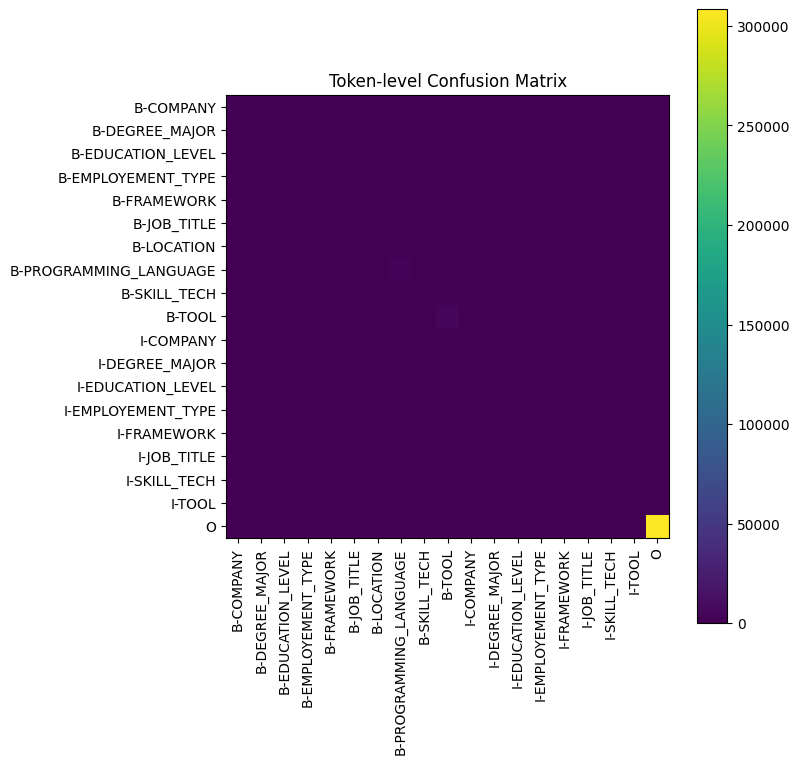

In [ ]:
#this iss then Confusion matrix (which labels get confused)
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

cm = confusion_matrix(flat_true, flat_pred, labels=list(id2label.keys()))

label_names = [id2label[i] for i in id2label.keys()]

fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(cm, interpolation="nearest")
ax.set_title("Token-level Confusion Matrix")
ax.set_xticks(np.arange(len(label_names)))
ax.set_yticks(np.arange(len(label_names)))
ax.set_xticklabels(label_names, rotation=90)
ax.set_yticklabels(label_names)
plt.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()


In [ ]:
#here is then “Most wrong” sentences (qualitative error analysis)
# Build per-sentence error counts
errors_per_sent = []

for sent_idx, (pred, lab) in enumerate(zip(pred_labels, labels)):
    sent_errors = 0
    total = 0
    for p_id, l_id in zip(pred, lab):
        if l_id == -100:
            continue
        total += 1
        if p_id != l_id:
            sent_errors += 1
    if total > 0:
        errors_per_sent.append((sent_idx, sent_errors, total))

# sort by error rate
errors_per_sent.sort(key=lambda x: x[1]/x[2], reverse=True)

# Show top 5 worst sentences
for idx, err, tot in errors_per_sent[:5]:
    print(f"\nSentence {idx} – errors {err}/{tot}")
    print("Tokens: ", tokens_list[idx])
    print("True : ", true_labels[idx])
    print("Pred : ", true_preds[idx])



Sentence 613 – errors 3/86
Tokens:  ['Our', 'company', 'participates', 'in', 'developing', 'a', 'the', 'next', 'generation', 'of', 'a', 'web', '-', 'based', 'geospatial', 'and', 'remote', 'sensing', 'data', 'processing', 'platform', 'that', 'reshapes', 'the', 'way', 'that', 'traditional', 'infrastructure', 'industry', 'operates', 'by', 'automation', 'of', 'inspection', '&', 'monitoring', 'processes', ',', 'creation', 'of', 'structures', '3D', 'Digital', 'Twin', 'through', 'Sensor', 'Fusion', ',', 'Artificial', 'Intellect', 'and', 'Big', 'Data', '.', 'We', 'are', 'currently', 'seeking', 'a', 'passionate', 'C', '+', '+', 'developer', 'with', 'a', 'deep', 'expertise', 'and', 'knowledge', 'of', '3D', 'Rendering', 'algorithms', 'who', 'can', 'solve', 'complex', 'problems', 'of', 'a', 'real', '-', 'time', '3D', 'rendering', '.', 'What', 'awaits', 'you', '?', 'As', 'a', 'member', 'of', 'our', 'international', 'development', 'team', 'you', 'will', 'contribute', 'to', 'a', 'forward', '-', 'loo

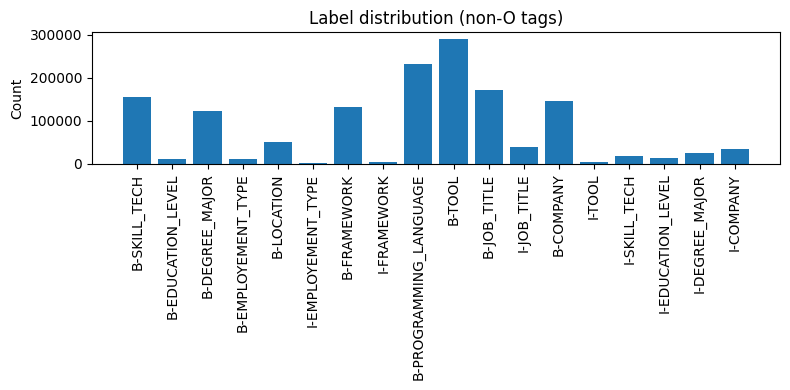

In [ ]:
#Label distribution bar plot (from our dataset)
import collections
import matplotlib.pyplot as plt

label_counts = collections.Counter()

for tags in tags_list:
    for tag in tags:
        if tag != "O":
            label_counts[tag] += 1

labels = list(label_counts.keys())
counts = [label_counts[l] for l in labels]

plt.figure(figsize=(8,4))
plt.bar(labels, counts)
plt.xticks(rotation=90)
plt.title("Label distribution (non-O tags)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


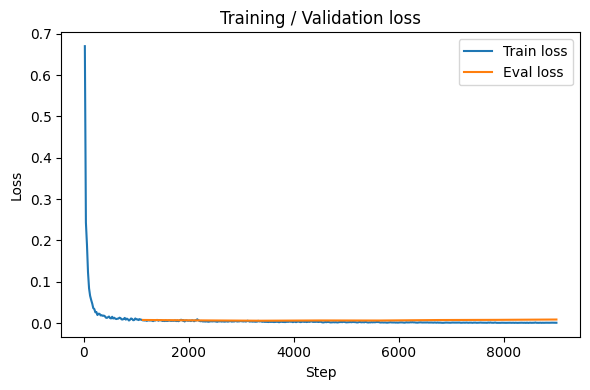

In [ ]:
#HuggingFace Trainer logs to trainer.state.log_history.
#Loss curve = great “learning curve” slide.
import matplotlib.pyplot as plt

logs = trainer.state.log_history

train_steps = []
train_losses = []
eval_steps = []
eval_losses = []

for entry in logs:
    if "loss" in entry and "epoch" in entry and "eval_loss" not in entry:
        train_steps.append(entry["step"])
        train_losses.append(entry["loss"])
    if "eval_loss" in entry:
        eval_steps.append(entry["step"])
        eval_losses.append(entry["eval_loss"])

plt.figure(figsize=(6,4))
plt.plot(train_steps, train_losses, label="Train loss")
if eval_losses:
    plt.plot(eval_steps, eval_losses, label="Eval loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training / Validation loss")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
from seqeval.metrics import classification_report

report = classification_report(true_labels, true_preds, output_dict=True)
report


{'COMPANY': {'precision': np.float64(0.8888248847926268),
  'recall': np.float64(0.8797035347776511),
  'f1-score': np.float64(0.8842406876790831),
  'support': np.int64(1754)},
 'DEGREE_MAJOR': {'precision': np.float64(1.0),
  'recall': np.float64(1.0),
  'f1-score': np.float64(1.0),
  'support': np.int64(721)},
 'EDUCATION_LEVEL': {'precision': np.float64(1.0),
  'recall': np.float64(0.967391304347826),
  'f1-score': np.float64(0.9834254143646408),
  'support': np.int64(92)},
 'EMPLOYEMENT_TYPE': {'precision': np.float64(0.9875),
  'recall': np.float64(1.0),
  'f1-score': np.float64(0.9937106918238994),
  'support': np.int64(79)},
 'FRAMEWORK': {'precision': np.float64(0.995274102079395),
  'recall': np.float64(1.0),
  'f1-score': np.float64(0.9976314542870678),
  'support': np.int64(1053)},
 'JOB_TITLE': {'precision': np.float64(0.9980379332897319),
  'recall': np.float64(0.9967341606792945),
  'f1-score': np.float64(0.9973856209150327),
  'support': np.int64(1531)},
 'LOCATION': {'

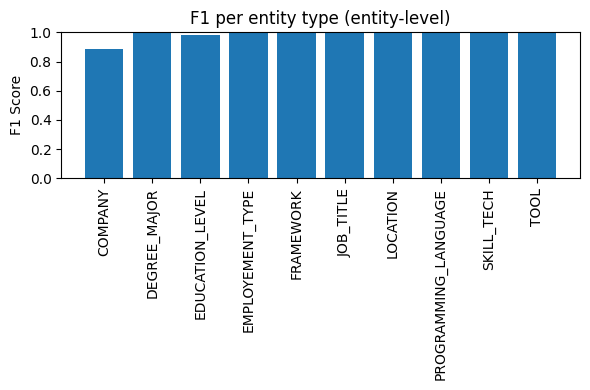

In [ ]:
import matplotlib.pyplot as plt

entity_labels = []
f1s = []

for k, v in report.items():
    if k in {"micro avg", "macro avg", "weighted avg"}:
        continue
    entity_labels.append(k)
    f1s.append(v["f1-score"])

plt.figure(figsize=(6,4))
plt.bar(entity_labels, f1s)
plt.xticks(rotation=90)
plt.ylabel("F1 Score")
plt.title("F1 per entity type (entity-level)")
plt.ylim(0,1)
plt.tight_layout()
plt.show()


In [ ]:
def ner_on_job_description(text: str):
    """
    Returns list of entities and also a structured dict label -> [values]
    """
    ents = predict_entities(text)

    by_type = {}
    for e in ents:
        by_type.setdefault(e["type"], []).append(e["text"])

    return ents, by_type


In [ ]:
jd = "We are hiring a Senior Python Developer at Google in London. You must know React and AWS."
ents, structured = ner_on_job_description(jd)
print("Entities:", ents)
print("Structured:", structured)


Entities: [{'type': 'PROGRAMMING_LANGUAGE', 'text': 'python'}, {'type': 'JOB_TITLE', 'text': 'developer'}, {'type': 'COMPANY', 'text': 'google'}, {'type': 'FRAMEWORK', 'text': 'react'}, {'type': 'TOOL', 'text': 'aw'}, {'type': 'TOOL', 'text': 's'}]
Structured: {'PROGRAMMING_LANGUAGE': ['python'], 'JOB_TITLE': ['developer'], 'COMPANY': ['google'], 'FRAMEWORK': ['react'], 'TOOL': ['aw', 's']}


In [ ]:
import pandas as pd

def entities_to_row(text: str):
    _, by_type = ner_on_job_description(text)
    row = {
        "job_title": ", ".join(by_type.get("JOB_TITLE", [])),
        "company": ", ".join(by_type.get("COMPANY", [])),
        "location": ", ".join(by_type.get("LOCATION", [])),
        "languages": ", ".join(by_type.get("PROGRAMMING_LANGUAGE", [])),
        "frameworks": ", ".join(by_type.get("FRAMEWORK", [])),
        "tools": ", ".join(by_type.get("TOOL", [])),
        "skills": ", ".join(by_type.get("SKILL_TECH", [])),
    }
    return row

examples = [
    "We are hiring a Senior Python Developer at Google in London. You must know React and AWS.",
    "Remote React Native Engineer for Facebook in New York. Experience with GraphQL and Docker required."
]

rows = [entities_to_row(t) for t in examples]
df = pd.DataFrame(rows)
df


,job_title,company,location,languages,frameworks,tools,skills
0,developer,google,,python,react,"aw, s",
1,engineer,facebook,remote,,react,"dock, er","graph, q, l"


In [ ]:
trainer.save_model("ner_model")
tokenizer.save_pretrained("ner_model")


('ner_model/tokenizer_config.json',
 'ner_model/special_tokens_map.json',
 'ner_model/vocab.txt',
 'ner_model/added_tokens.json',
 'ner_model/tokenizer.json')

In [ ]:
%%writefile app.py
import streamlit as st
import torch
from transformers import AutoTokenizer, AutoModelForTokenClassification

MODEL_DIR = "ner_model"  # or your output dir

@st.cache_resource
def load_model():
    tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR)
    model = AutoModelForTokenClassification.from_pretrained(MODEL_DIR)
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    id2label = model.config.id2label
    return tokenizer, model, id2label, device

tokenizer, model, id2label, device = load_model()

def predict_entities(text: str):
    words = text.split()
    encoding = tokenizer(words, is_split_into_words=True,
                         return_tensors="pt", truncation=True)
    encoding = {k: v.to(device) for k, v in encoding.items()}

    with torch.no_grad():
        outputs = model(**encoding)

    logits = outputs.logits
    preds = logits.argmax(dim=-1)[0].tolist()
    tokens = tokenizer.convert_ids_to_tokens(encoding["input_ids"][0])

    entities = []
    current = None

    for token, pred_id in zip(tokens, preds):
        if token in ["[CLS]", "[SEP]", "[PAD]"]:
            continue

        label = id2label[pred_id]
        if label == "O":
            if current:
                entities.append(current)
                current = None
            continue

        tag, ent_type = label.split("-", 1)
        is_subword = token.startswith("##")
        piece = token[2:] if is_subword else token

        if tag == "B" or (current and current["type"] != ent_type):
            if current:
                entities.append(current)
            current = {"type": ent_type, "text": piece}
        else:
            if current is None:
                current = {"type": ent_type, "text": piece}
            else:
                if is_subword:
                    current["text"] += piece
                else:
                    current["text"] += " " + piece

    if current:
        entities.append(current)
    return entities

st.title("Job Description NER Demo")

default_text = "We are hiring a Senior Python Developer at Google in London. You must know React and AWS."
text = st.text_area("Paste a job description:", default_text, height=200)

if st.button("Extract entities"):
    ents = predict_entities(text)
    st.write("### Extracted entities")
    for e in ents:
        st.write(f"**{e['type']}**: {e['text']}")


Overwriting app.py


In [ ]:
!pip install pyngrok streamlit -q

from pyngrok import ngrok

# paste ONLY the raw token string between the quotes:
#ngrok.set_auth_token("YOUR_NEW_TOKEN_HERE")


In [ ]:
ngrok.set_auth_token("363MF6W2a2DavrN4RMBWLBpxENV_2L6rt77zoAKPNJbfBnhC7")


In [ ]:
!streamlit run app.py &>/dev/null&
public_url = ngrok.connect(8501)
public_url


<NgrokTunnel: "https://marylyn-nonmakeup-maryjo.ngrok-free.dev" -> "http://localhost:8501">

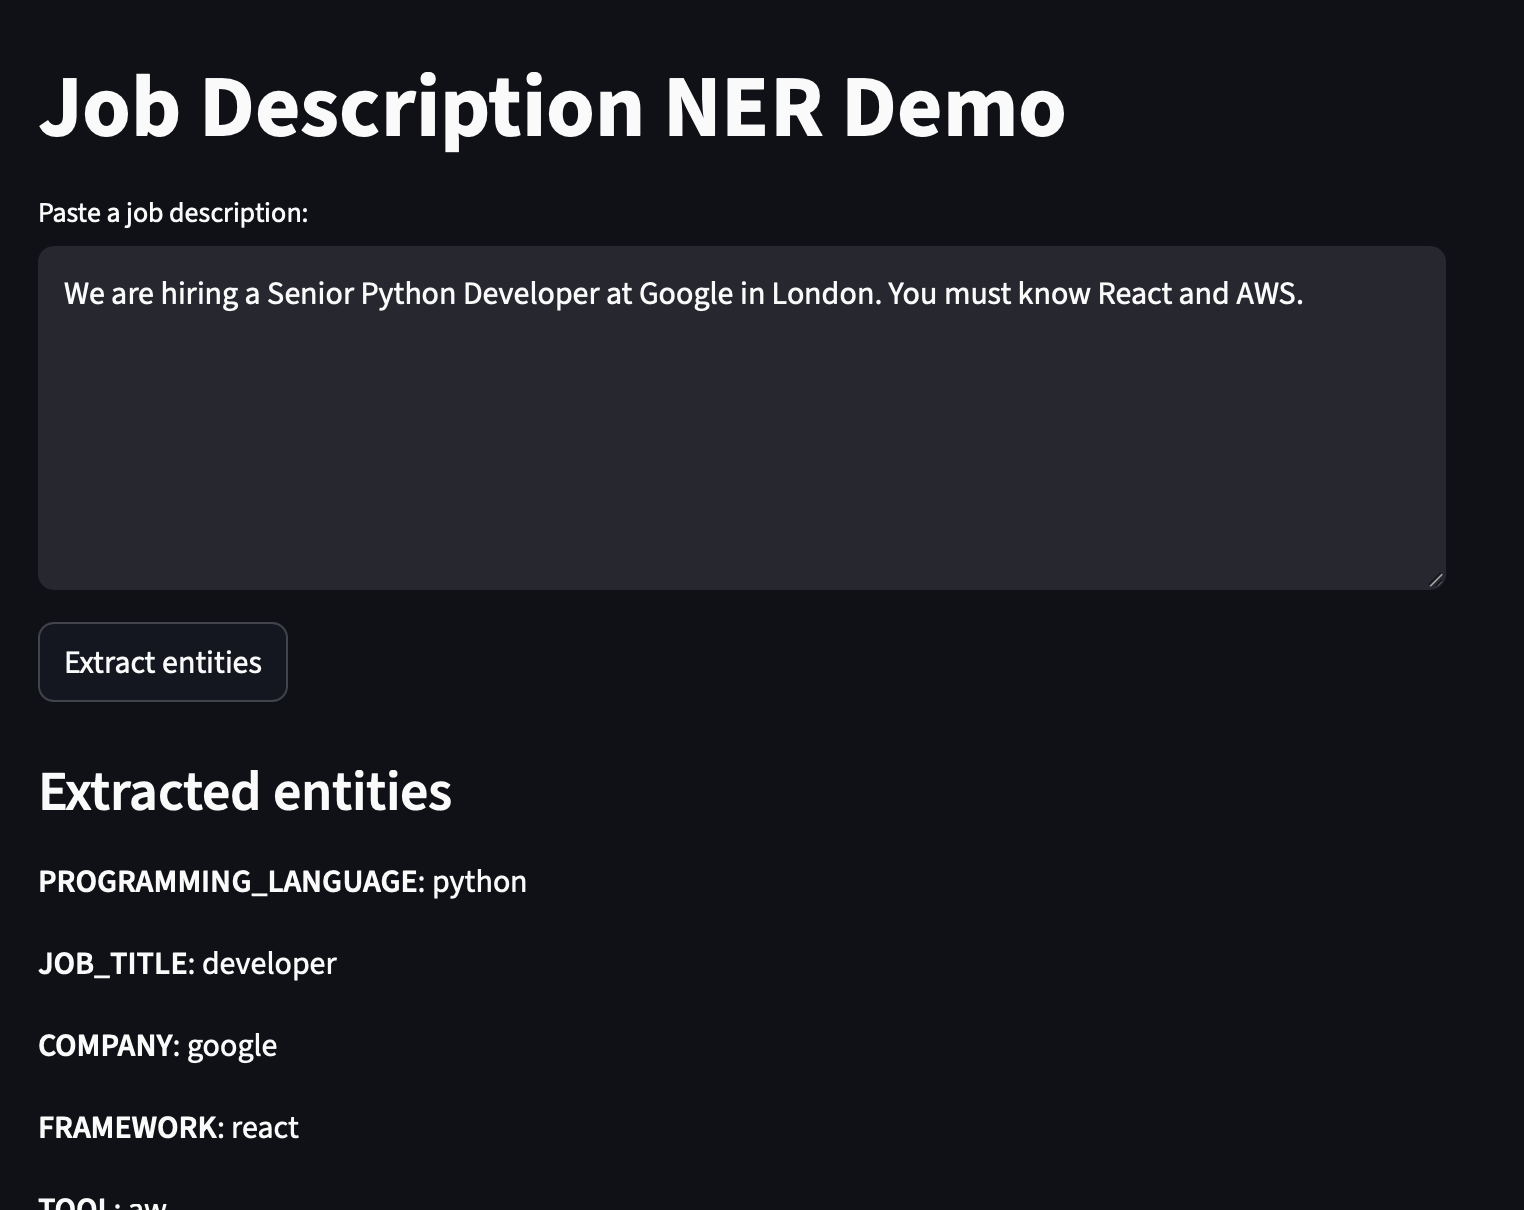